In [1]:
import pandas as pd
import numpy as np


# for Modelling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

from tensorflow.keras.models import load_model

# for Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.metrics import mean_absolute_percentage_error


In [2]:
df= pd.read_csv('by_t1.csv')
df

,Time id,Material,Quantity,Total_Value,Material_Id
0,1,C24-100504,3.0,38991.70,1311
1,1,C24-700110,28.0,60159.68,1421
2,1,C29-700105,2.0,28757.51,1610
3,1,C37-500419,4.0,51712.67,1755
4,1,C87-200404,3.0,146492.80,4756
...,...,...,...,...,...
382,38,S06-010053,9.0,73800.00,6464
383,38,S10-020027,116.0,75397.39,7263
384,38,S23-170301,111.0,120978.90,30765
385,38,S23-240014,150.0,82446.74,8710


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

# Function to build and train RNN models
def build_and_train_model(model_type, X_train, y_train):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    return model

# Initialize an empty DataFrame to store the forecast results
forecast_df = pd.DataFrame(columns=['Time id', 'Material id', 'Model', 'Actual Quantity', 'Forecasted', 'MAE', 'MAPE', 'R2'])

# Iterate over each material id
for material_id in df['Material_Id'].unique():
    print(f"Forecasting for Material ID: {material_id}")

    # Filter data for the current material id
    material_data = df[df['Material_Id'] == material_id]

    # Split data into train and test sets
    train = material_data[(material_data['Time id'] >= 13) & (material_data['Time id'] <= 26)]
    test = material_data[material_data['Time id'] == 27]

    # Check if both train and test sets have at least one sample
    if len(train) == 0 or len(test) == 0:
        print(f"Skipping Material ID: {material_id} due to empty train or test set.")
        continue

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train[['Quantity']])
    test_scaled = scaler.transform(test[['Quantity']])

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(train_scaled, (train_scaled.shape[0], 1, 1))
    X_test = np.reshape(test_scaled, (test_scaled.shape[0], 1, 1))
    y_train = train_scaled[:, 0]  # Target variable is Quantity

    # Iterate over each model type
    for model_type in ['SimpleRNN', 'GRU', 'LSTM']:
        print(f"Forecasting with {model_type} model for Material ID: {material_id}")

        # Build and train model
        model = build_and_train_model(model_type, X_train, y_train)

        # Forecast for the test set
        forecasted_values = model.predict(X_test)
        forecasted_values_inv = scaler.inverse_transform(forecasted_values)

        # Get actual quantity for the test set
        actual_quantity = test['Quantity'].values[0]

        # Calculate MAE and MAPE
        mae = mean_absolute_error([actual_quantity], forecasted_values_inv[0])
        mape = mean_absolute_percentage_error([actual_quantity], forecasted_values_inv[0])

        # Calculate R²
        mse = mean_squared_error([actual_quantity], forecasted_values_inv[0])
        r2 = 1 - (mse / (actual_quantity ** 2))  # Simplified R² calculation

        # Append results to the dataframe
        forecast_df = forecast_df.append({
            'Time id': 27,
            'Material id': material_id,
            'Model': model_type,
            'Actual Quantity': actual_quantity,
            'Forecasted': forecasted_values_inv[0][0],
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }, ignore_index=True)

# Display the forecast results dataframe
print(forecast_df)



Forecasting for Material ID: 1311
Forecasting with SimpleRNN model for Material ID: 1311


C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Forecasting with GRU model for Material ID: 1311


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Forecasting with LSTM model for Material ID: 1311


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Forecasting for Material ID: 1421
Forecasting with SimpleRNN model for Material ID: 1421


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Forecasting with GRU model for Material ID: 1421


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Forecasting with LSTM model for Material ID: 1421


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Forecasting for Material ID: 1610
Forecasting with SimpleRNN model for Material ID: 1610


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Forecasting with GRU model for Material ID: 1610


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Forecasting with LSTM model for Material ID: 1610


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Forecasting for Material ID: 1755
Forecasting with SimpleRNN model for Material ID: 1755


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Forecasting with GRU model for Material ID: 1755


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Forecasting with LSTM model for Material ID: 1755


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Forecasting for Material ID: 4756
Forecasting with SimpleRNN model for Material ID: 4756


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Forecasting with GRU model for Material ID: 4756


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Forecasting with LSTM model for Material ID: 4756


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Forecasting for Material ID: 6345
Forecasting with SimpleRNN model for Material ID: 6345


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Forecasting with GRU model for Material ID: 6345


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Forecasting with LSTM model for Material ID: 6345


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Forecasting for Material ID: 6464
Forecasting with SimpleRNN model for Material ID: 6464


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Forecasting with GRU model for Material ID: 6464


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Forecasting with LSTM model for Material ID: 6464


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Forecasting for Material ID: 7263
Forecasting with SimpleRNN model for Material ID: 7263


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Forecasting with GRU model for Material ID: 7263


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Forecasting with LSTM model for Material ID: 7263


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Forecasting for Material ID: 8710
Forecasting with SimpleRNN model for Material ID: 8710


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Forecasting with GRU model for Material ID: 8710


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Forecasting with LSTM model for Material ID: 8710


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Forecasting for Material ID: 12481
Forecasting with SimpleRNN model for Material ID: 12481


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Forecasting with GRU model for Material ID: 12481


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Forecasting with LSTM model for Material ID: 12481


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Forecasting for Material ID: 25056
Forecasting with SimpleRNN model for Material ID: 25056


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Forecasting with GRU model for Material ID: 25056


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Forecasting with LSTM model for Material ID: 25056


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Forecasting for Material ID: 30765
Forecasting with SimpleRNN model for Material ID: 30765


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Forecasting with GRU model for Material ID: 30765


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Forecasting with LSTM model for Material ID: 30765


C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Forecasting for Material ID: 32814
Skipping Material ID: 32814 due to empty train or test set.
   Time id Material id      Model  Actual Quantity  Forecasted        MAE  \
0       27        1311  SimpleRNN              4.0    3.916253   0.083747   
1       27        1311        GRU              4.0    3.792202   0.207798   
2       27        1311       LSTM              4.0    3.509259   0.490741   
3       27        1421  SimpleRNN             28.0   28.412815   0.412815   
4       27        1421        GRU             28.0   28.868530   0.868530   
5       27        1421       LSTM             28.0   30.377560   2.377560   
6       27        1610  SimpleRNN              4.0    3.925970   0.074030   
7       27        1610        GRU              4.0    3.776134   0.223866   
8       27        1610       LSTM              4.0    3.584343   0.415657   
9       27        1755  SimpleRNN              6.0    7.064363   1.064363   
10      27        1

C:\Users\sohan\AppData\Local\Temp\ipykernel_22396\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({


In [4]:
# Group forecast results by model
grouped_results = forecast_df.groupby('Model')

# Calculate overall MAE, MAPE, and R2 scores for each model
for model_type, group in grouped_results:
    overall_mae = group['MAE'].mean()
    overall_mape = group['MAPE'].mean()
    overall_r2 = group['R2'].mean()
    
    # Print the overall scores for the current model
    print(f"Overall scores for {model_type} model:")
    print("Overall MAE:", overall_mae)
    print("Overall MAPE:", overall_mape)
    print("Overall R2:", overall_r2)
    print()

Overall scores for GRU model:
Overall MAE: 5.15108464161555
Overall MAPE: 0.0997496017572501
Overall R2: 0.9843904744231828

Overall scores for LSTM model:
Overall MAE: 6.843263804912567
Overall MAPE: 0.13968334764376253
Overall R2: 0.9740492995911351

Overall scores for SimpleRNN model:
Overall MAE: 2.5038254261016846
Overall MAPE: 0.05963573028102686
Overall R2: 0.9936727133392941



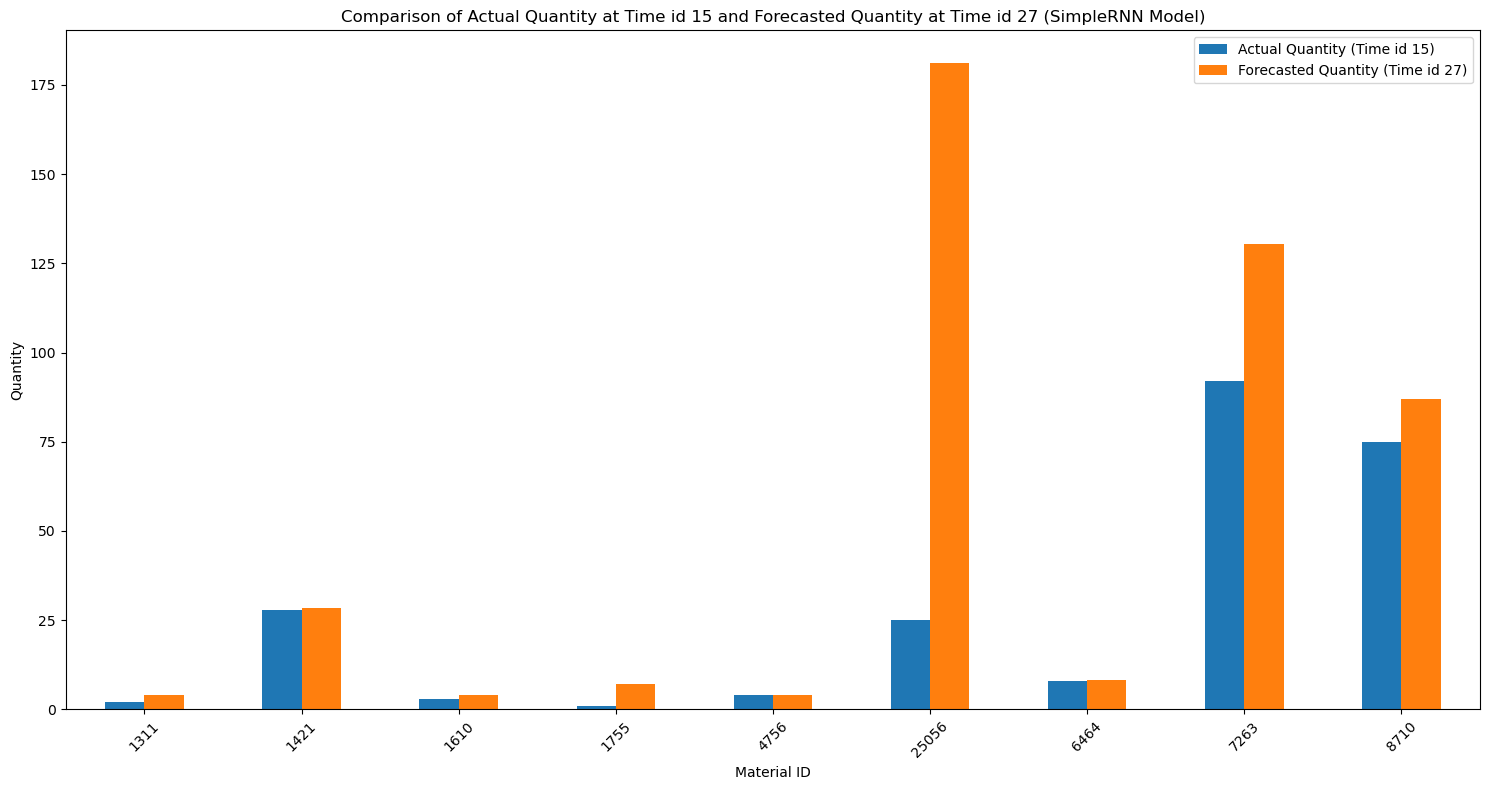

In [5]:
import matplotlib.pyplot as plt

# Filter df for Time id 27
actual_quantities = df[df['Time id'] == 15][['Material_Id', 'Quantity']]
actual_quantities = actual_quantities.set_index('Material_Id')

# Filter forecast_df for Time id 27 and SimpleRNN model
forecasted_quantities = forecast_df[(forecast_df['Time id'] == 27) & (forecast_df['Model'] == 'SimpleRNN')][['Material id', 'Forecasted']]
forecasted_quantities = forecasted_quantities.rename(columns={'Material id': 'Material_Id'})
forecasted_quantities = forecasted_quantities.set_index('Material_Id')

# Merge actual and forecasted quantities
merged_df = actual_quantities.join(forecasted_quantities, how='inner', lsuffix='_actual', rsuffix='_forecasted')

# Plotting
merged_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Material ID')
plt.ylabel('Quantity')
plt.title('Comparison of Actual Quantity at Time id 15 and Forecasted Quantity at Time id 27 (SimpleRNN Model)')
plt.xticks(rotation=45)
plt.legend(['Actual Quantity (Time id 15)', 'Forecasted Quantity (Time id 27)'])
plt.tight_layout()
plt.show()

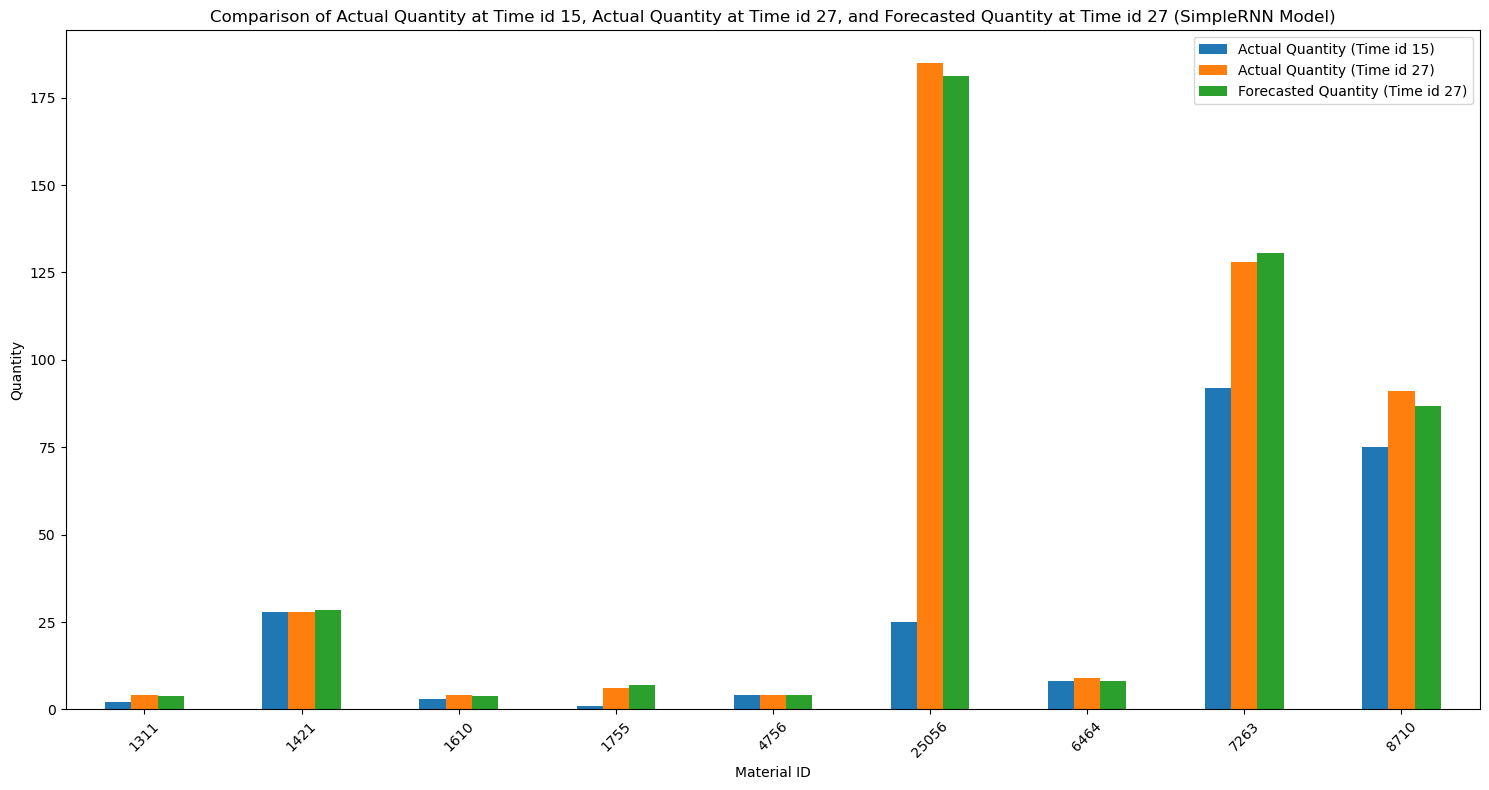

In [6]:
import matplotlib.pyplot as plt

# Filter df for Time id 15
actual_quantities_15 = df[df['Time id'] == 15][['Material_Id', 'Quantity']]
actual_quantities_15 = actual_quantities_15.set_index('Material_Id')

# Filter df for Time id 27
actual_quantities_27 = df[df['Time id'] == 27][['Material_Id', 'Quantity']]
actual_quantities_27 = actual_quantities_27.set_index('Material_Id')

# Filter forecast_df for Time id 27 and SimpleRNN model
forecasted_quantities = forecast_df[(forecast_df['Time id'] == 27) & (forecast_df['Model'] == 'SimpleRNN')][['Material id', 'Forecasted']]
forecasted_quantities = forecasted_quantities.rename(columns={'Material id': 'Material_Id'})
forecasted_quantities = forecasted_quantities.set_index('Material_Id')

# Merge actual quantities at Time id 15, Time id 27, and forecasted quantities
merged_df = actual_quantities_15.join(actual_quantities_27, how='inner', lsuffix='_actual_15', rsuffix='_actual_27')
merged_df = merged_df.join(forecasted_quantities, how='inner')

# Plotting
merged_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Material ID')
plt.ylabel('Quantity')
plt.title('Comparison of Actual Quantity at Time id 15, Actual Quantity at Time id 27, and Forecasted Quantity at Time id 27 (SimpleRNN Model)')
plt.xticks(rotation=45)
plt.legend(['Actual Quantity (Time id 15)', 'Actual Quantity (Time id 27)', 'Forecasted Quantity (Time id 27)'])
plt.tight_layout()
plt.show()
